In [1]:
# from funs import *

# #####################################
# # 그래프 보고자 하는 타겟 디렉토리 설정     
# target_dir = '../output/0814'
# ######################################

# # example)
# # dir_list = get_dir_list(target_dir, target_fault_type='B')
# # dir_list = get_dir_list(target_dir, target_view='T')
# # dir_list = get_dir_list(target_dir, target_fault_type='B', target_view='F')

# dir_list = get_dir_list(target_dir, target_fault_type='B')

# # example)
# # draw_single_graphs(dir_list, ['x.csv', 'z.csv'])
# # draw_single_graphs(dir_list, ['a.csv']) ------------> 잘못된 csv 파일, ValueError

# draw_single_graphs(dir_list)

# dir_list = get_dir_list(target_dir, target_fault_type='OR')
# draw_single_graphs(dir_list)

In [2]:
# from funs import *

# #####################################
# # 그래프 보고자 하는 타겟 디렉토리 설정     
# target_dir = '../output/0814'
# ######################################

# # example)
# # dir_list = get_dir_list(target_dir, target_fault_type='B')
# # dir_list = get_dir_list(target_dir, target_view='T')
# # dir_list = get_dir_list(target_dir, target_fault_type='B', target_view='F')

# dir_list = get_dir_list(target_dir, target_fault_type='B')

# # example)
# # draw_single_graphs(dir_list, ['x.csv', 'z.csv'])
# # draw_single_graphs(dir_list, ['a.csv']) ------------> 잘못된 csv 파일, ValueError

# compare_graphs(dir_list)

[('../output/1001/1001_30204_B_F/x.csv',               A         B
0     -0.004577  0.125530
1     -0.109764 -0.098620
2     -0.131991 -0.136031
3     -0.134912 -0.130194
4     -0.134912 -0.130195
...         ...       ...
71065 -0.090149 -0.054964
71066  0.016781  0.048398
71067  0.110197  0.174993
71068  0.191428  0.242947
71069  0.275740  0.275688

[71070 rows x 2 columns])]


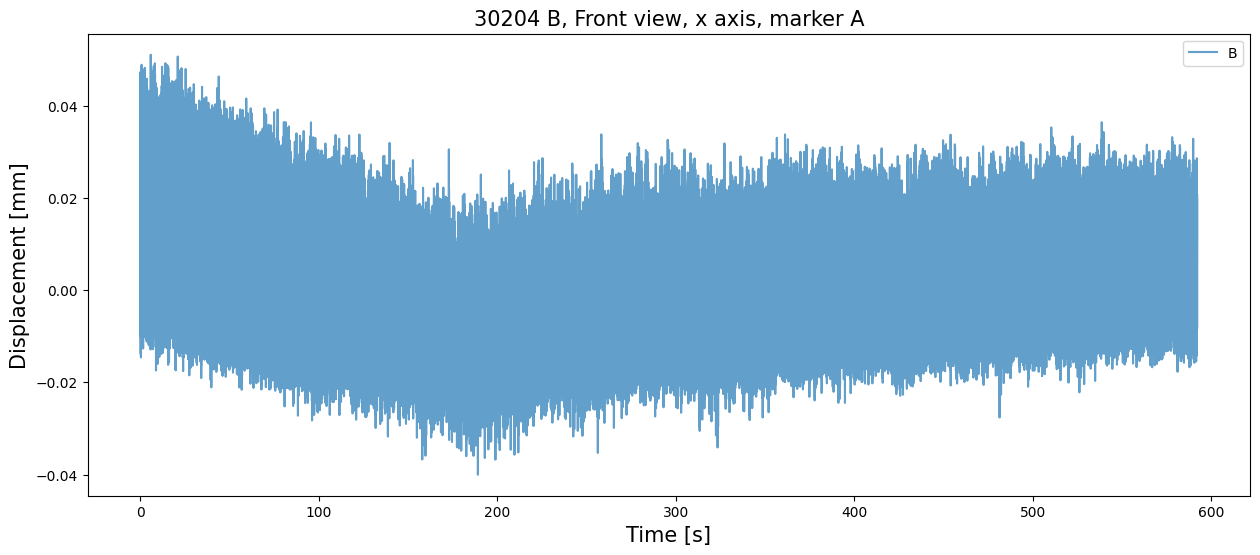

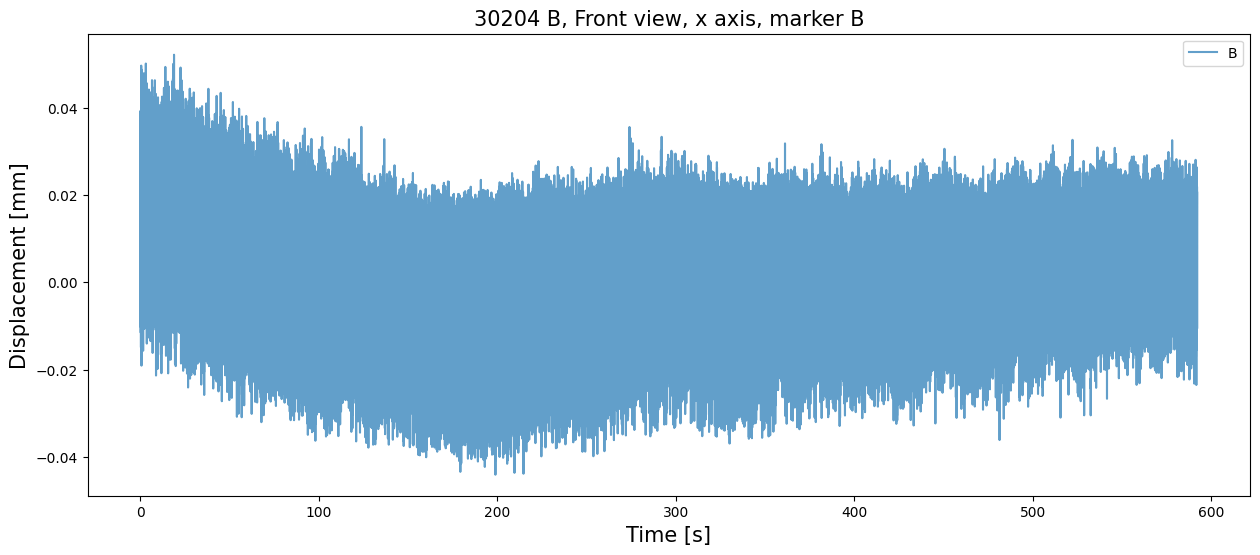

[('../output/1001/1001_30204_B_F/z.csv',               A         B
0      0.129573  0.075350
1      0.062465  0.024403
2      0.034105 -0.023677
3      0.021864 -0.031388
4      0.021860 -0.031392
...         ...       ...
71065  0.004199 -0.040469
71066 -0.227896 -0.195740
71067 -0.258566 -0.214272
71068 -0.256667 -0.190652
71069 -0.195215 -0.173252

[71070 rows x 2 columns])]


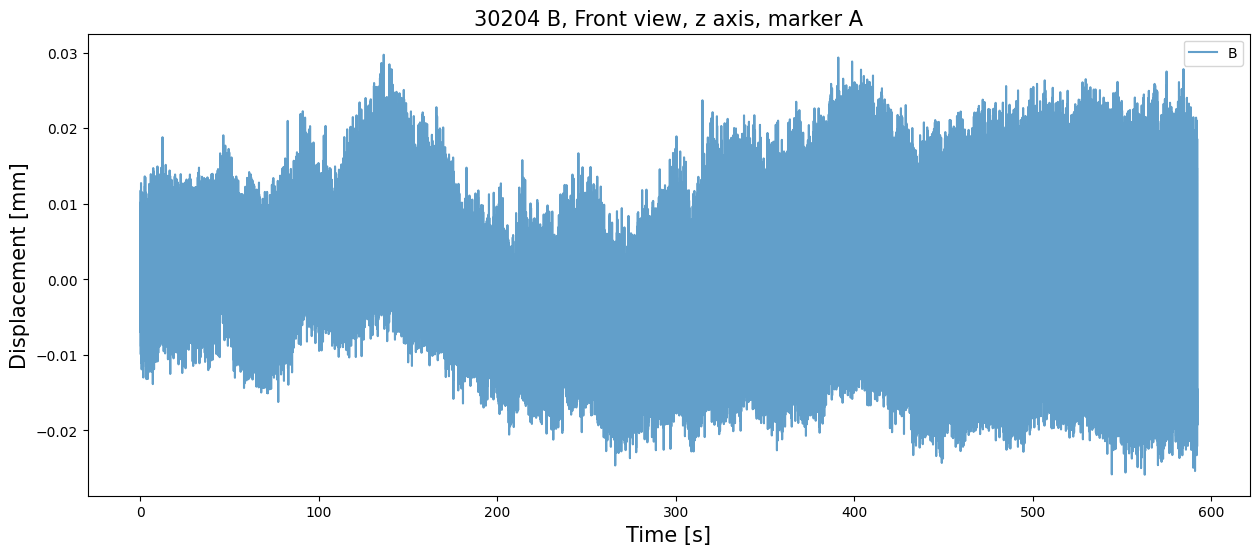

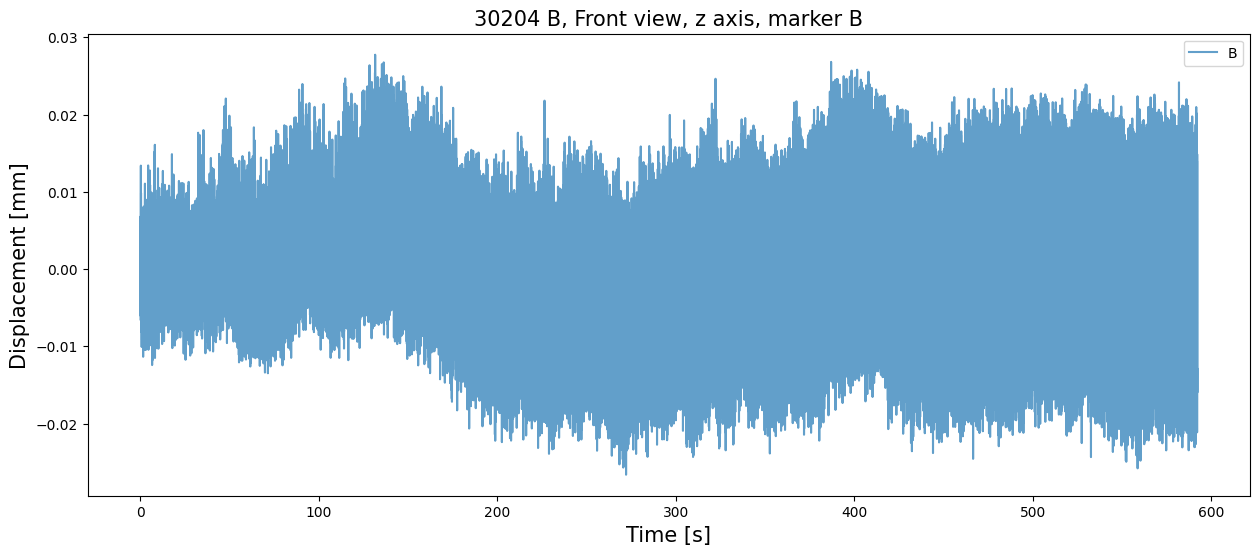

[('../output/1001/1001_30204_B_S/y.csv',               A         B
0     -0.148930  1.031225
1     -0.145437  1.026888
2     -0.146303  1.026867
3     -0.091433  1.068297
4     -0.065645  1.134634
...         ...       ...
76597 -0.284800 -0.309539
76598 -0.263578 -0.300436
76599 -0.338629 -0.331354
76600 -0.369966 -0.326321
76601 -0.367536 -0.343094

[76602 rows x 2 columns])]


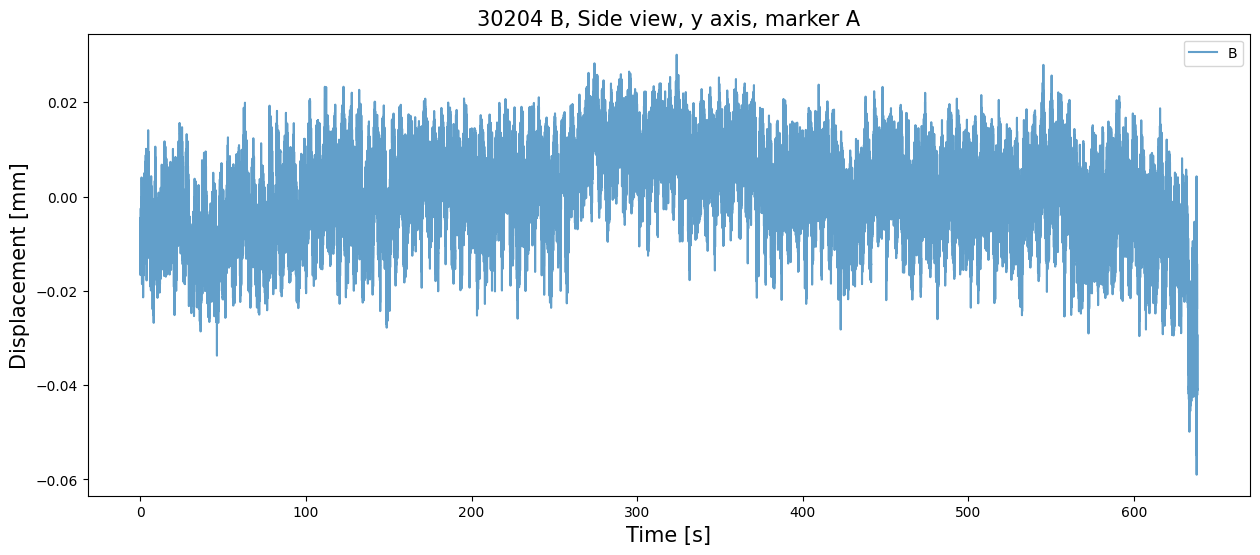

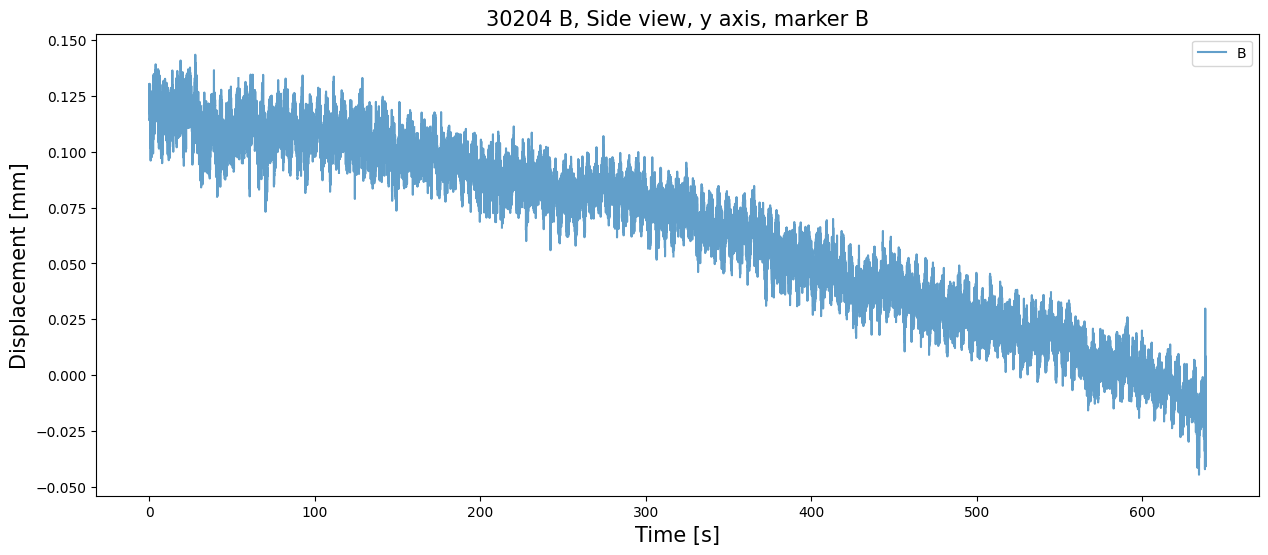

[('../output/1001/1001_30204_B_S/z.csv',               A         B
0      0.144620  1.340520
1      0.153622  1.335980
2      0.135328  1.335962
3      0.046748  1.305793
4      0.019574  1.284622
...         ...       ...
76597 -1.439288 -1.639238
76598 -1.621752 -1.684885
76599 -1.789052 -1.889468
76600 -1.811391 -1.878440
76601 -1.861116 -1.890497

[76602 rows x 2 columns])]


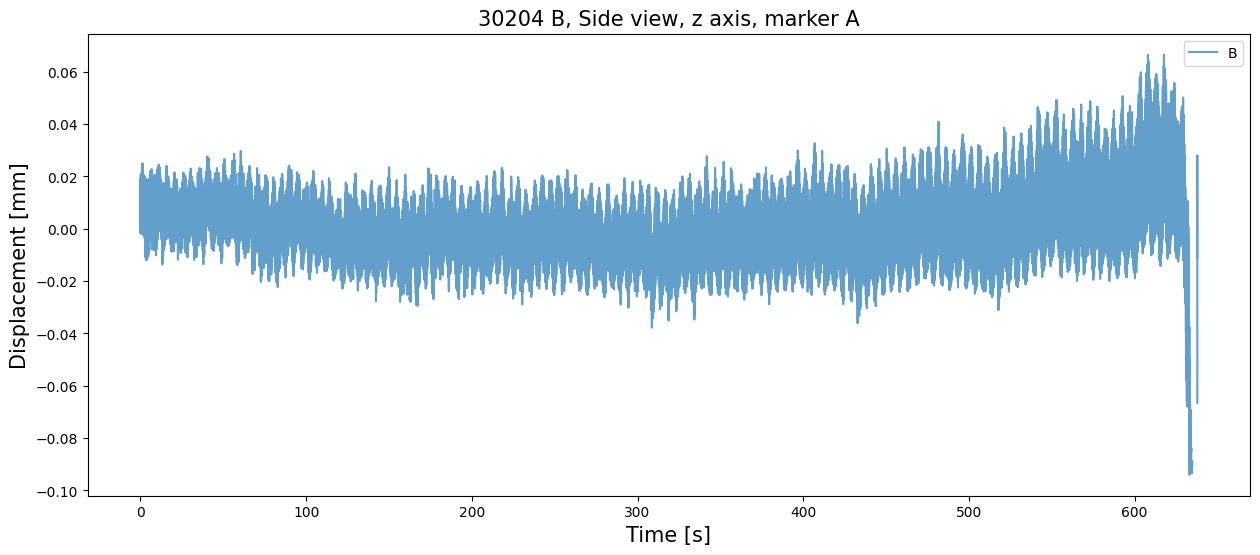

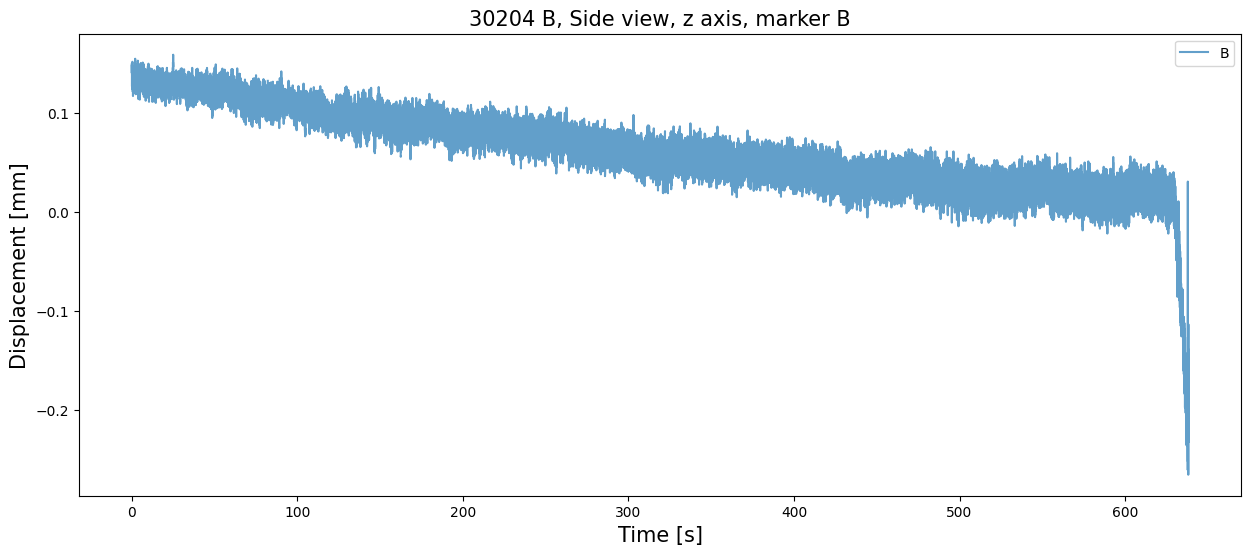

[('../output/1001/1001_30204_IR_F/x.csv',               A         B
0     -0.028145  0.050610
1     -0.043830 -0.018968
2     -0.096193 -0.052347
3     -0.088661 -0.052091
4     -0.088661 -0.039253
...         ...       ...
74446 -0.659353 -0.676008
74447 -0.659353 -0.676010
74448 -0.355536 -0.339315
74449 -0.079321 -0.118590
74450  0.055993  0.165206

[74451 rows x 2 columns])]


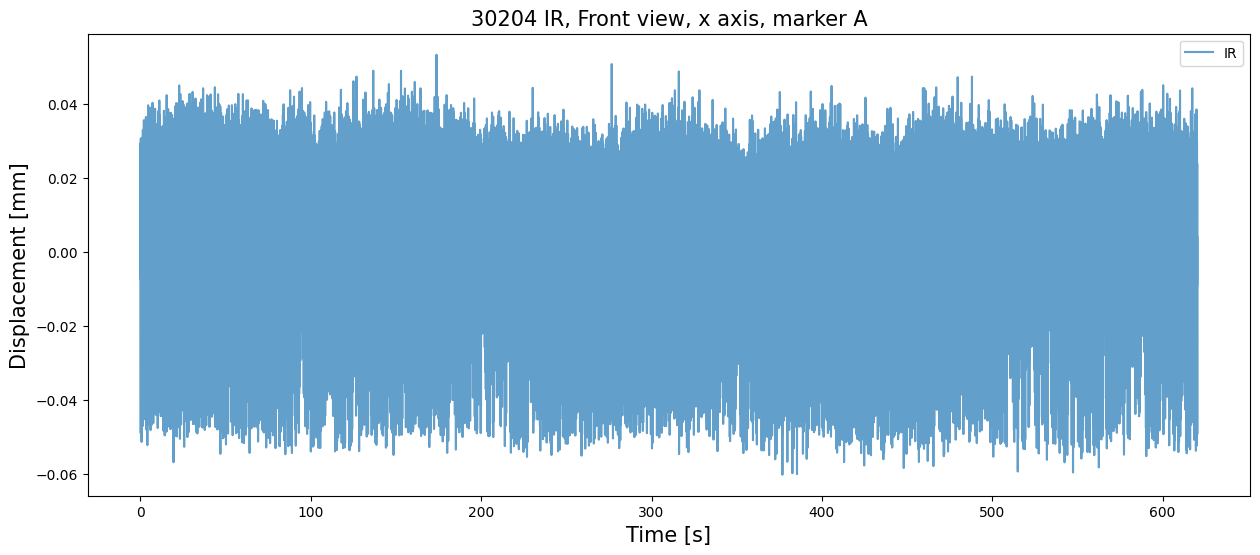

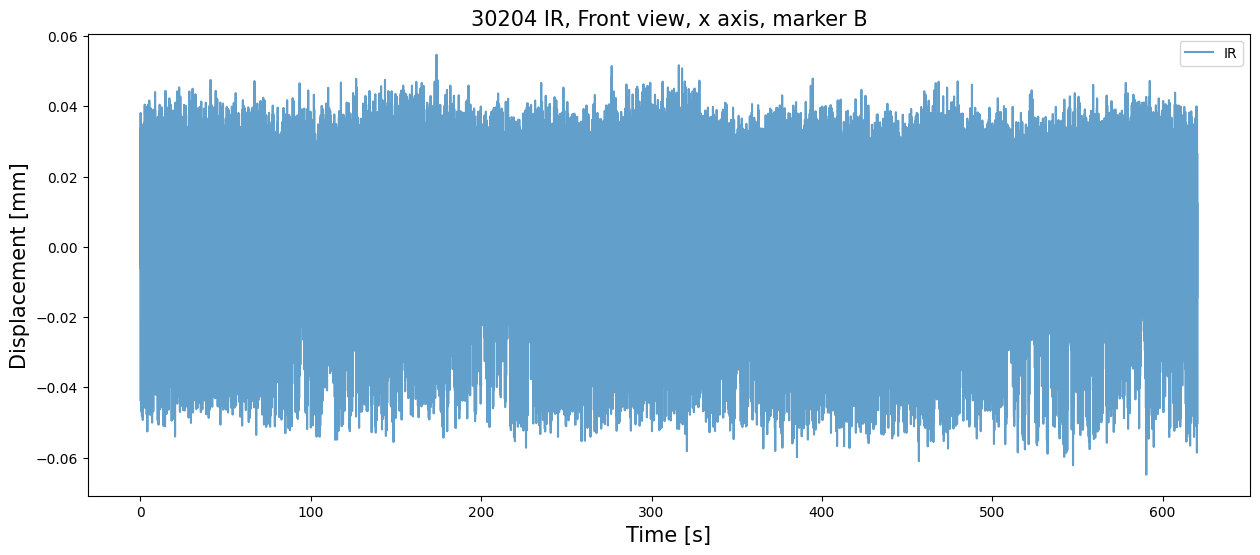

[('../output/1001/1001_30204_IR_F/z.csv',               A         B
0      0.196015  0.096344
1      0.248413  0.195125
2      0.273009  0.283410
3      0.251976  0.284039
4      0.251955  0.234790
...         ...       ...
74446  0.138737  0.206237
74447  0.138716  0.206216
74448  0.006897  0.060317
74449 -0.103851 -0.117913
74450 -0.278106 -0.307049

[74451 rows x 2 columns])]


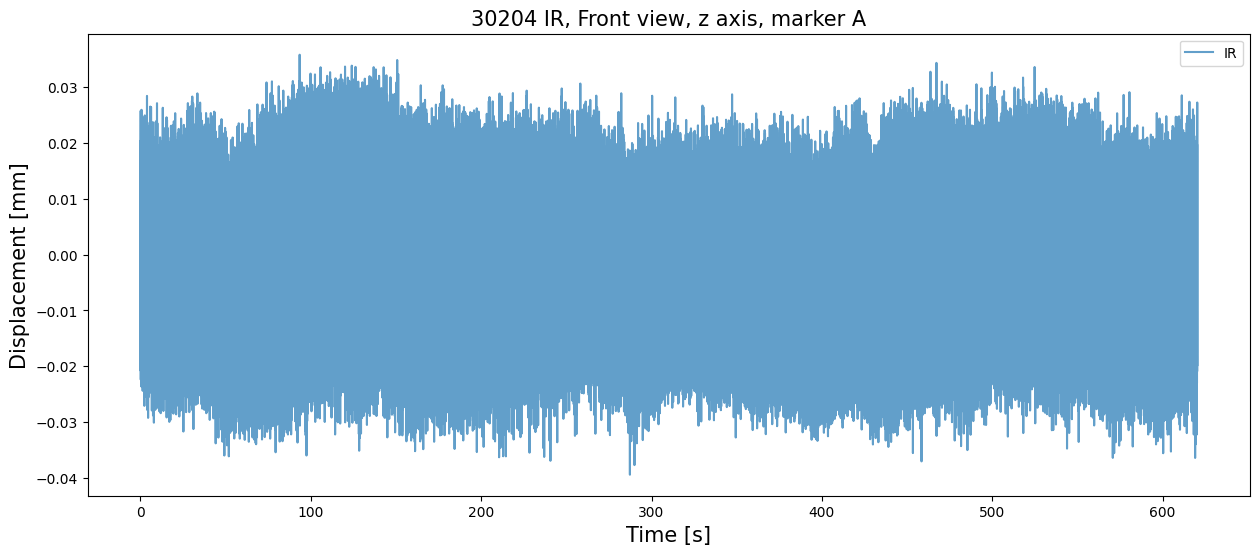

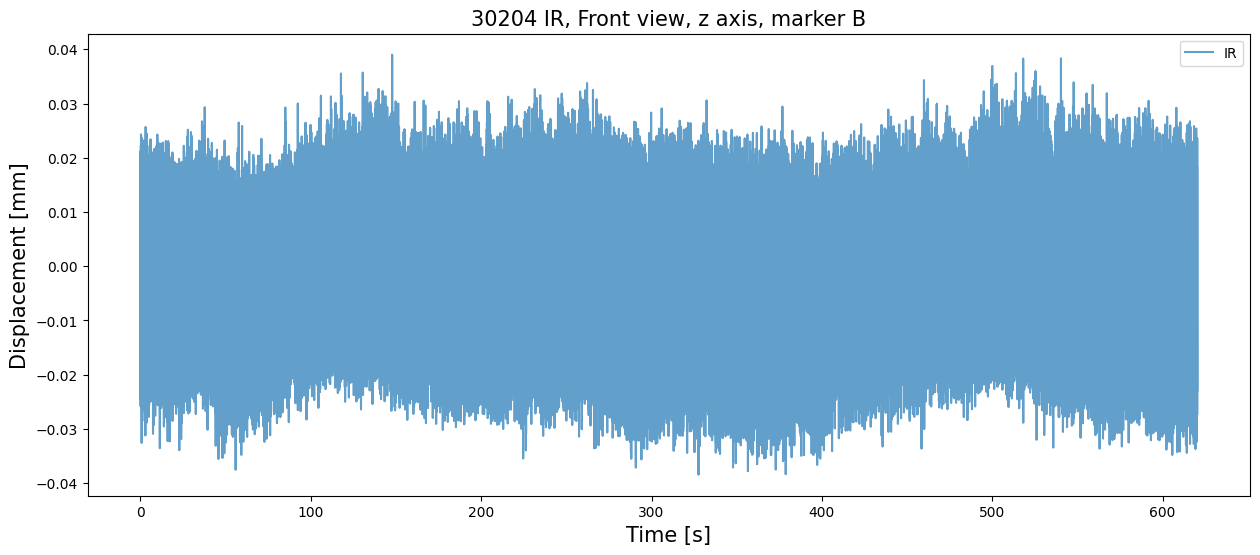

[('../output/1001/1001_30204_IR_S/y.csv',               A         B
0     -0.124857 -0.065829
1     -0.124058 -0.058635
2     -0.054621 -0.010860
3     -0.016899  0.012839
4     -0.016901  0.004928
...         ...       ...
75847 -0.004421 -0.092938
75848 -0.022999 -0.116953
75849 -0.023001 -0.105181
75850  0.022424 -0.078824
75851  0.022422 -0.079352

[75852 rows x 2 columns])]


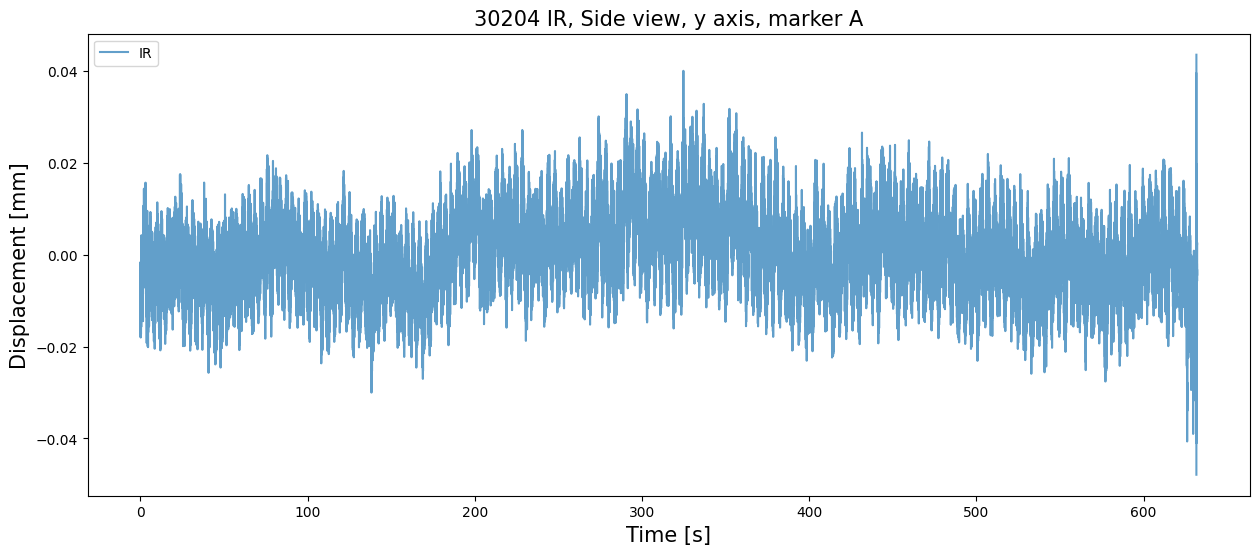

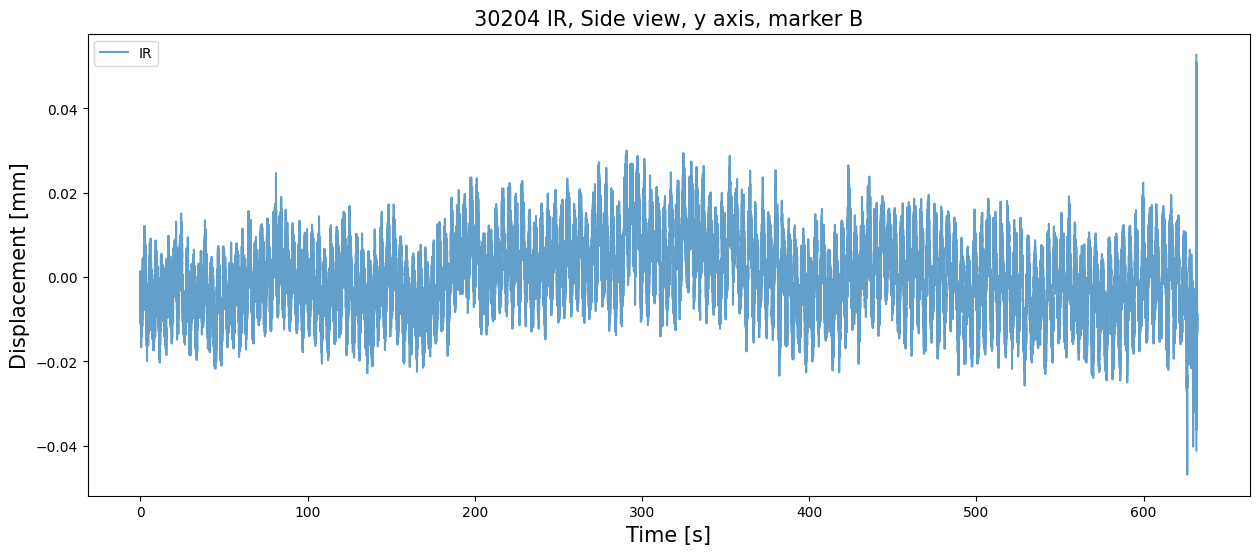

[('../output/1001/1001_30204_IR_S/z.csv',               A         B
0     -0.148897 -0.250076
1     -0.184641 -0.246477
2      0.071885 -0.153298
3      0.208480  0.028064
4      0.208469  0.050297
...         ...       ...
75847  0.001763 -0.137646
75848 -0.010426 -0.154630
75849 -0.010437 -0.143272
75850 -0.305536 -0.148431
75851 -0.305547 -0.156523

[75852 rows x 2 columns])]


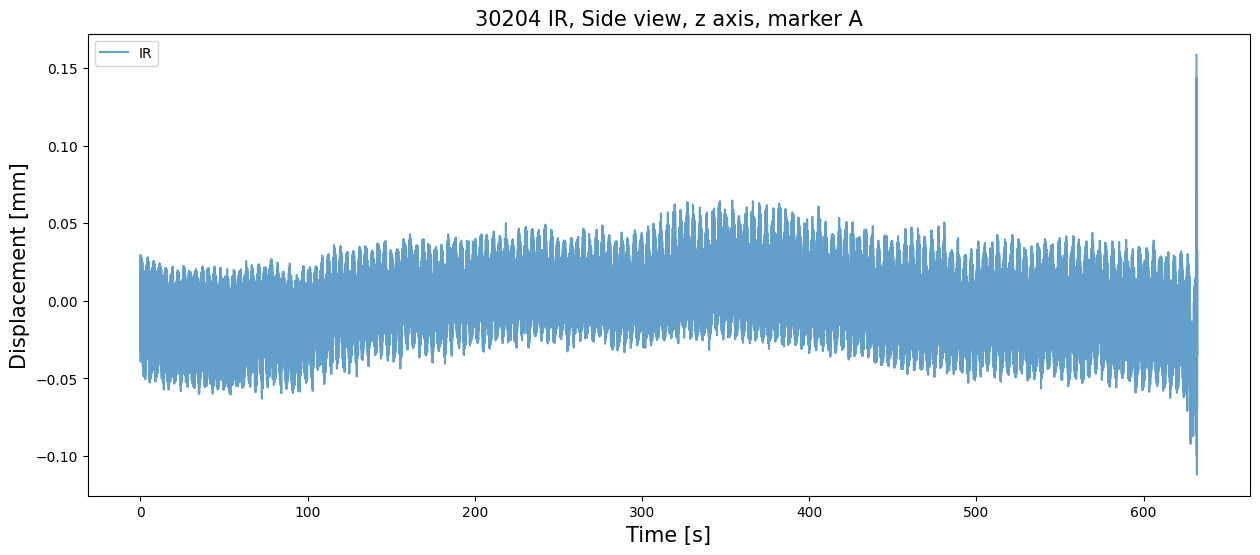

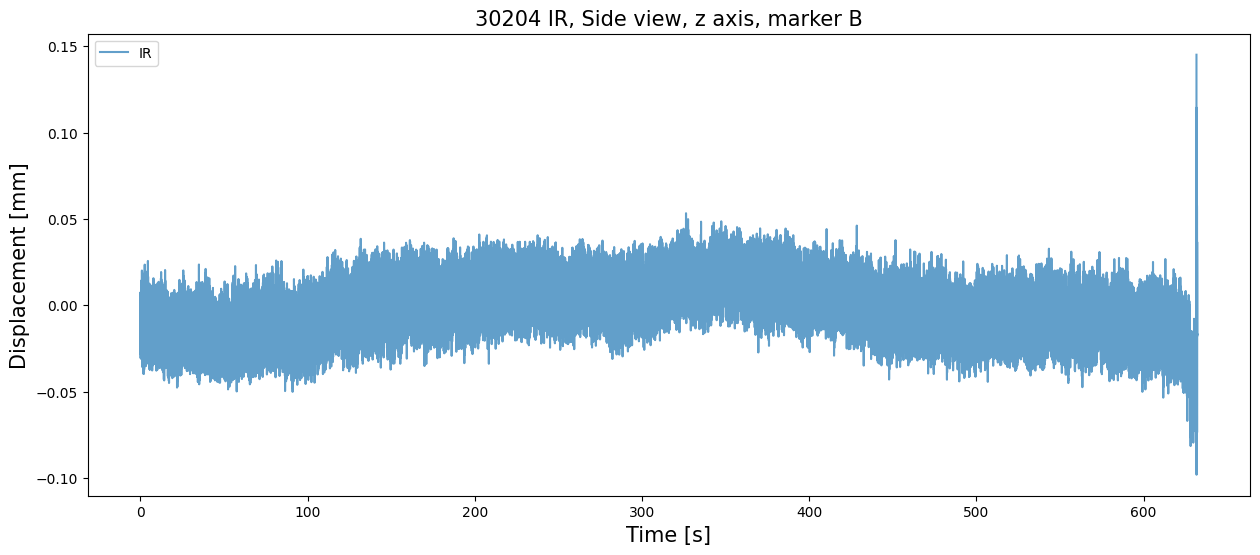

[('../output/1001/1001_30204_OR_F/x.csv',               A         B
0     -0.067800 -0.141072
1     -0.102413 -0.208603
2     -0.180823 -0.218114
3     -0.180823 -0.218116
4     -0.064261 -0.082949
...         ...       ...
76928 -0.176251 -0.230102
76929 -0.176251 -0.252714
76930 -0.169498 -0.247106
76931 -0.171207 -0.153851
76932  0.042592  0.131810

[76933 rows x 2 columns])]


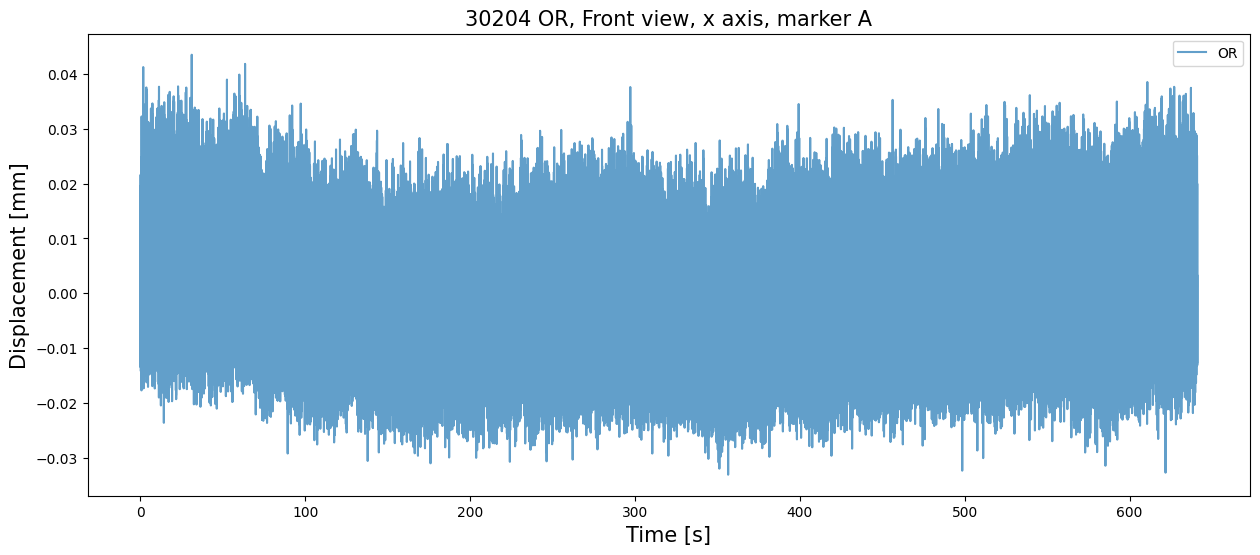

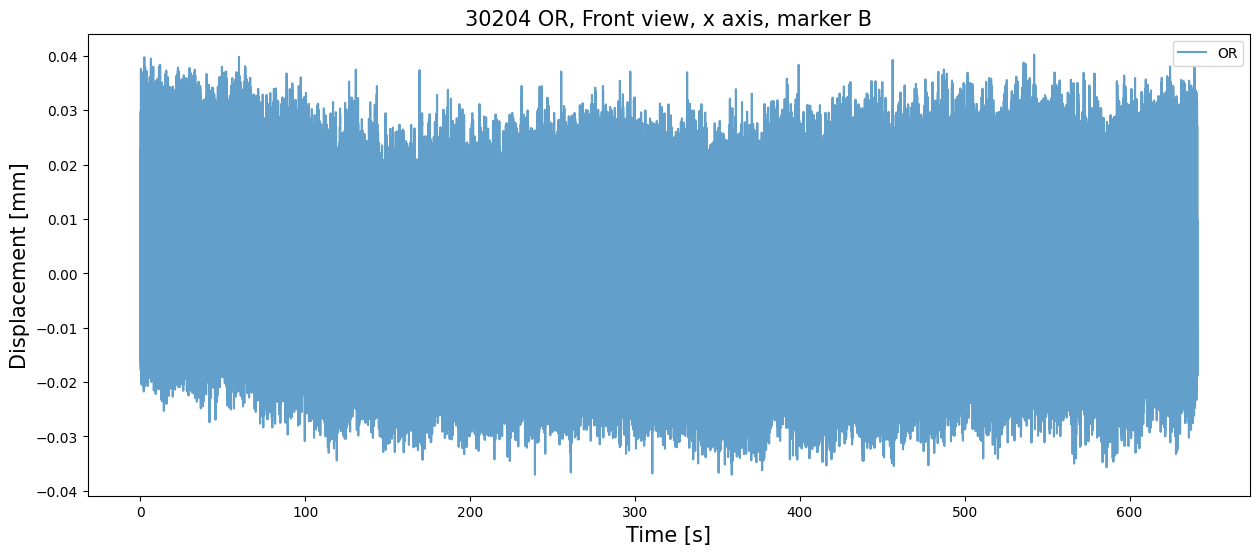

[('../output/1001/1001_30204_OR_F/z.csv',               A         B
0      0.283515  0.227475
1      0.256277  0.184244
2      0.274779  0.226459
3      0.274767  0.226448
4      0.168844  0.122821
...         ...       ...
76928  0.082385 -0.012387
76929  0.082373  0.003386
76930  0.067421  0.031586
76931  0.047262  0.053054
76932 -0.016061 -0.031514

[76933 rows x 2 columns])]


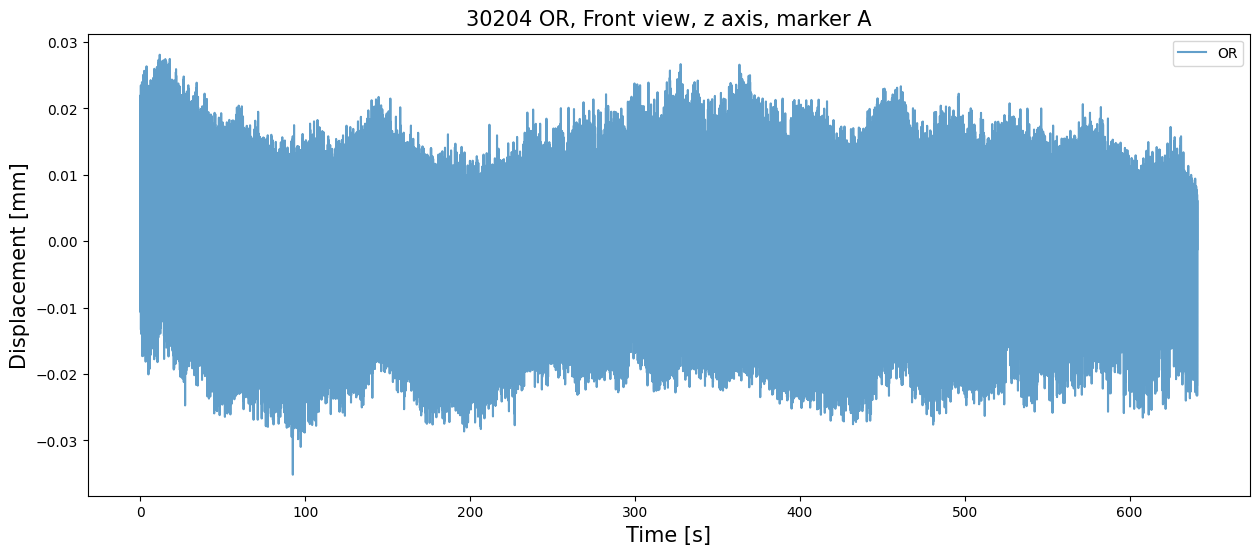

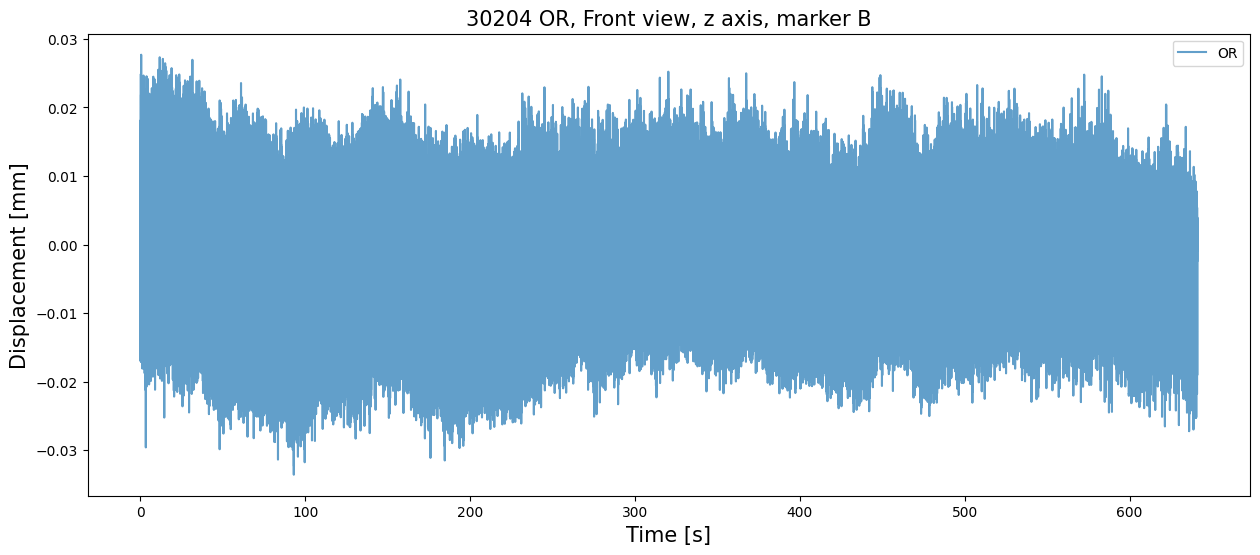

[('../output/1001/1001_30204_OR_S/y.csv',               A         B
0      0.046880 -0.133558
1      0.046872 -0.139548
2      0.021727 -0.088680
3      0.032659 -0.133618
4      0.037644 -0.100775
...         ...       ...
79271 -0.026544 -0.001412
79272 -0.014516 -0.026452
79273  0.004746 -0.034422
79274 -0.015161  0.008712
79275 -0.005535  0.009664

[79276 rows x 2 columns])]


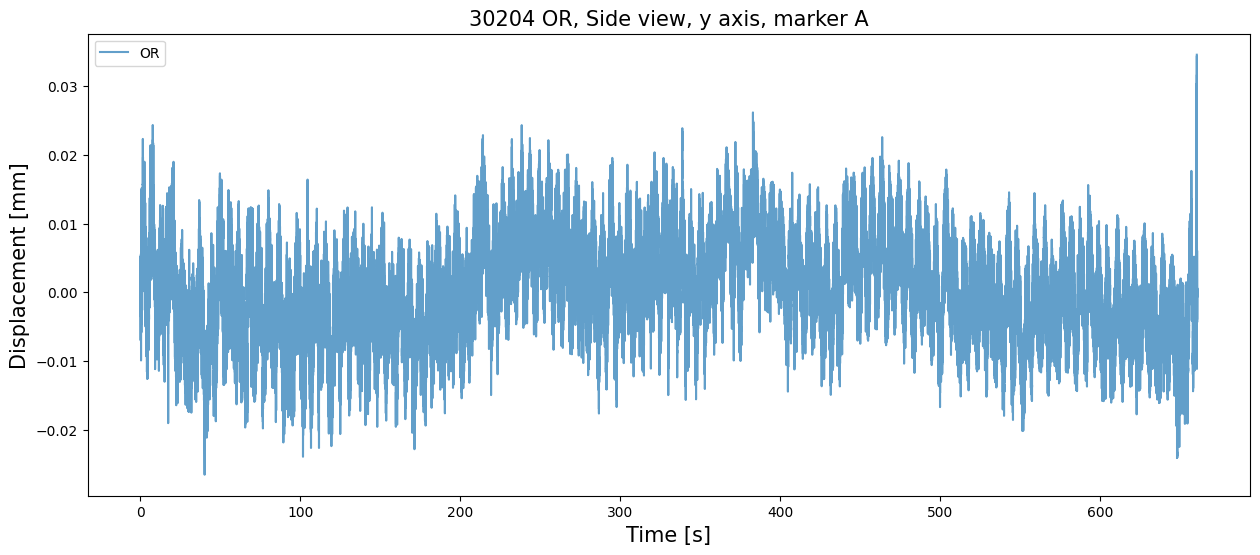

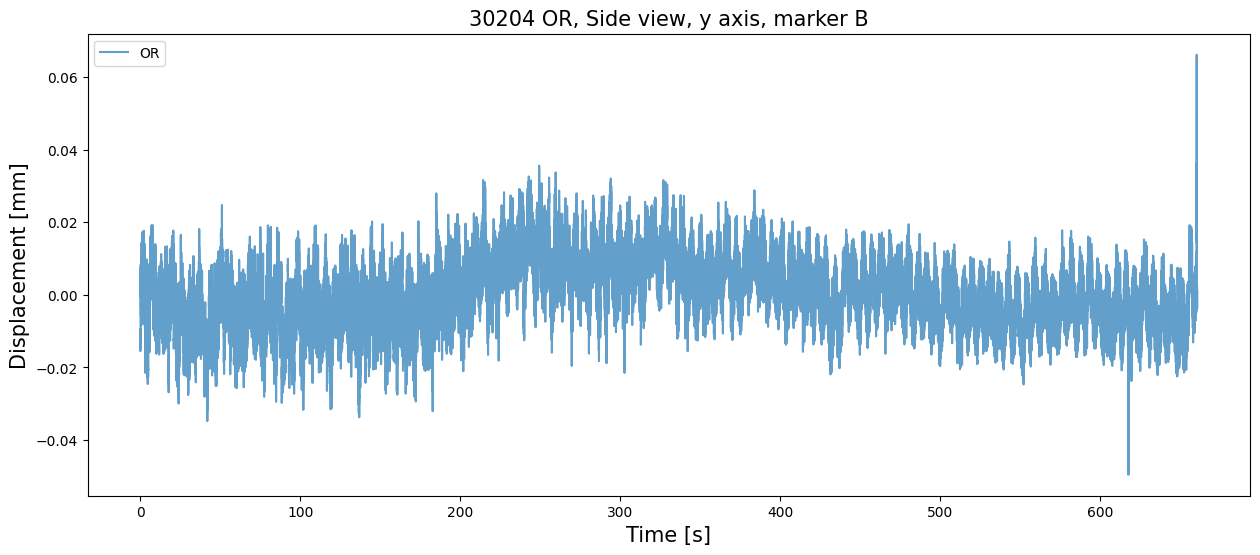

[('../output/1001/1001_30204_OR_S/z.csv',               A         B
0      0.221229  0.142195
1      0.221223  0.136304
2      0.008833  0.013354
3     -0.199559 -0.037239
4     -0.283797 -0.145994
...         ...       ...
79271 -0.321420 -0.294254
79272 -0.469311 -0.289742
79273 -0.494491 -0.318960
79274 -0.531417 -0.368815
79275 -0.528710 -0.377446

[79276 rows x 2 columns])]


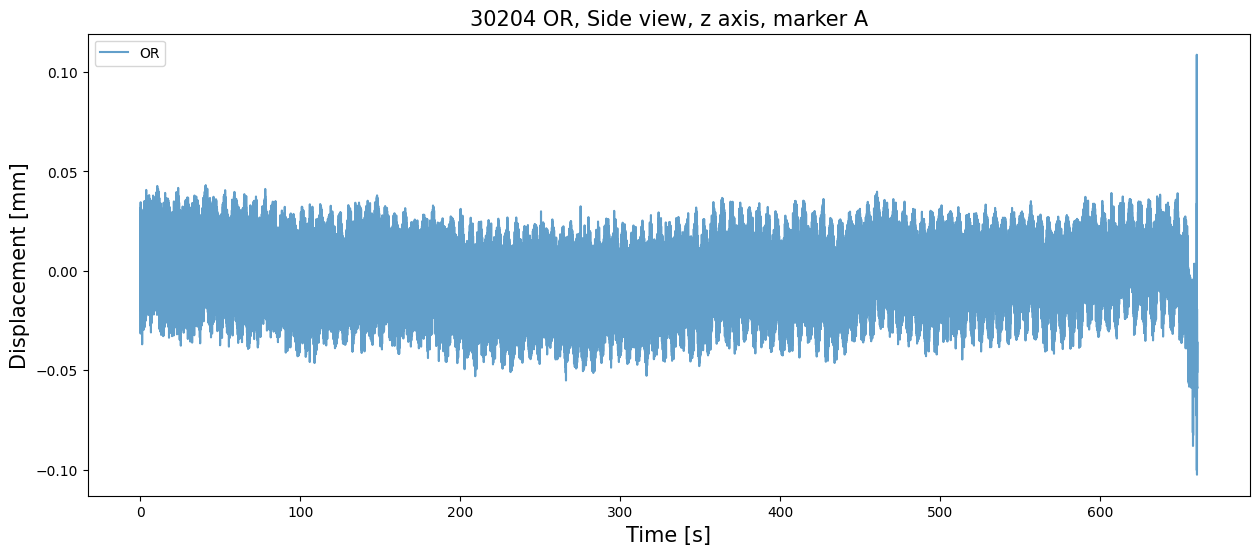

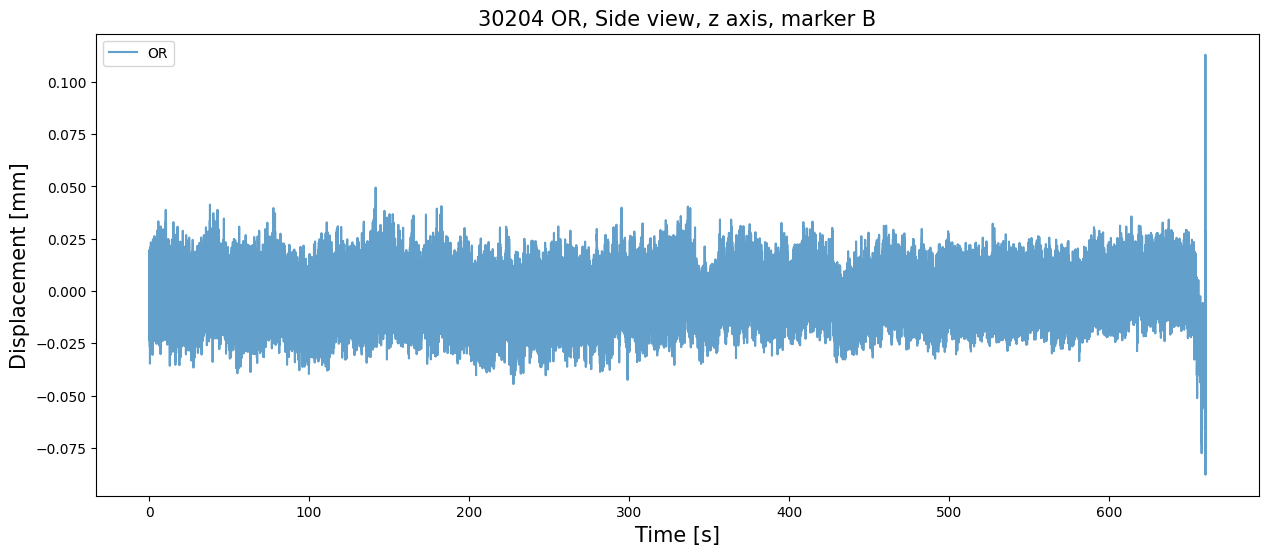

In [3]:
from funs import *

#####################################
# 그래프 보고자 하는 타겟 디렉토리 설정     
target_dir = '../output/1001'
######################################

# example)
# dir_list = get_dir_list(target_dir, target_fault_type='B')
# dir_list = get_dir_list(target_dir, target_view='T')
# dir_list = get_dir_list(target_dir, target_fault_type='B', target_view='F')

dir_list = get_dir_list(target_dir)

# example)
# draw_single_graphs(dir_list, ['x.csv', 'z.csv'])
# draw_single_graphs(dir_list, ['a.csv']) ------------> 잘못된 csv 파일, ValueError

compare_graphs(dir_list)

[('../output/1004/1004_30204_H_F/x.csv',               A         B
0     -0.206475 -0.228647
1     -0.234235 -0.224765
2     -0.276945 -0.240339
3     -0.264493 -0.197375
4      0.021849 -0.030676
...         ...       ...
77562 -0.064047 -0.181822
77563 -0.064063 -0.178177
77564 -0.026603 -0.075604
77565  0.147509  0.050501
77566  0.179928  0.116312

[77567 rows x 2 columns])]


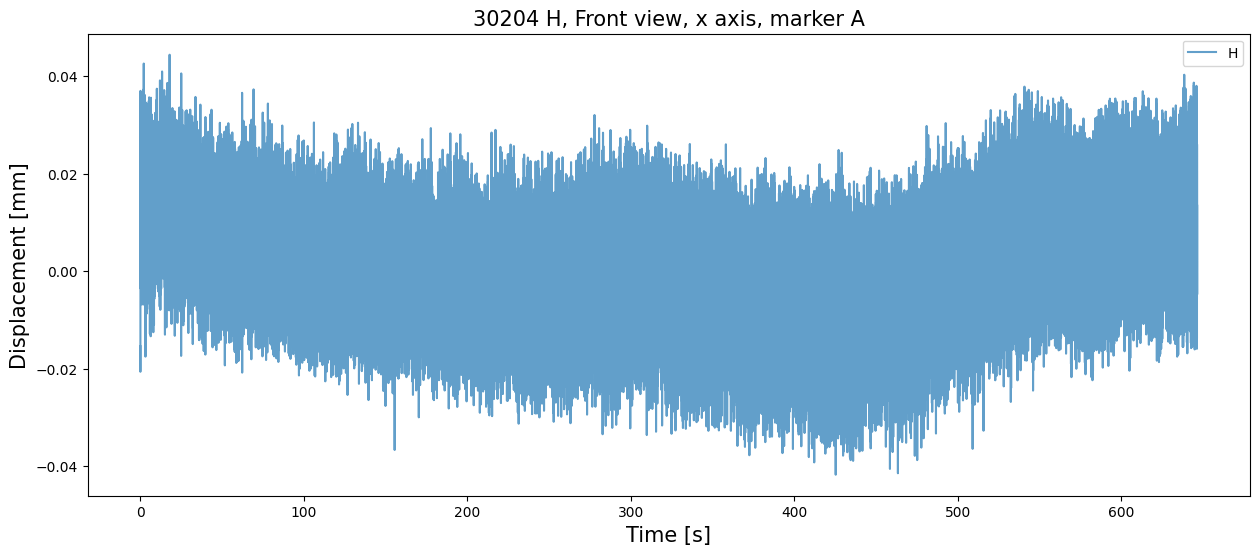

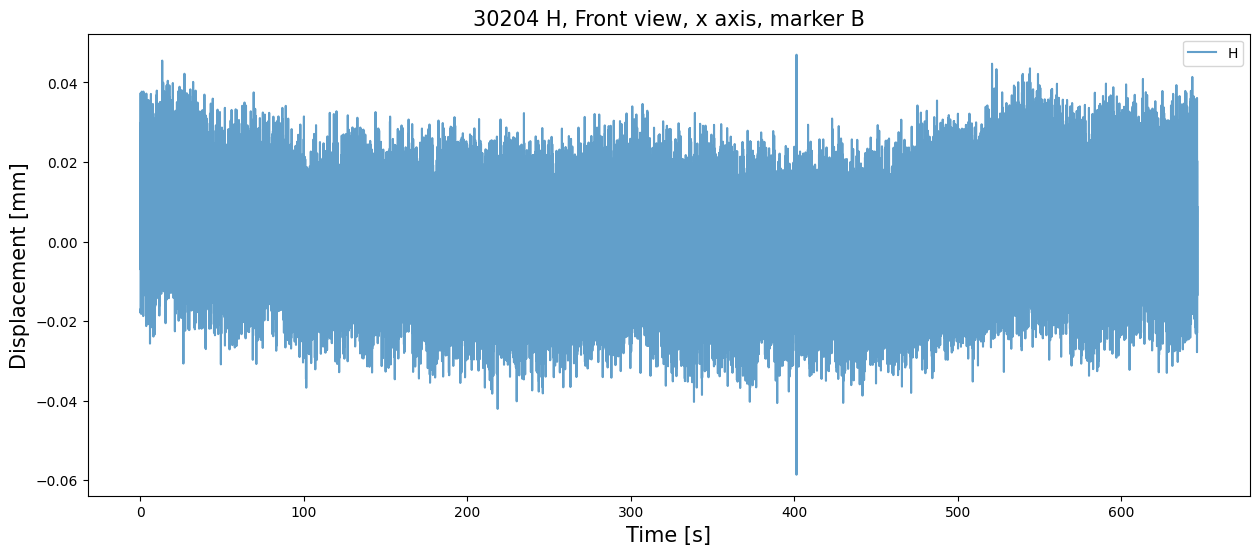

[('../output/1004/1004_30204_H_F/z.csv',               A         B
0      0.143574  0.188259
1      0.155187  0.156256
2      0.174131  0.158105
3      0.073087  0.124488
4     -0.163162 -0.025629
...         ...       ...
77562  0.384296  0.384734
77563  0.384257  0.396125
77564  0.340029  0.293197
77565  0.091429  0.135054
77566 -0.021894  0.086484

[77567 rows x 2 columns])]


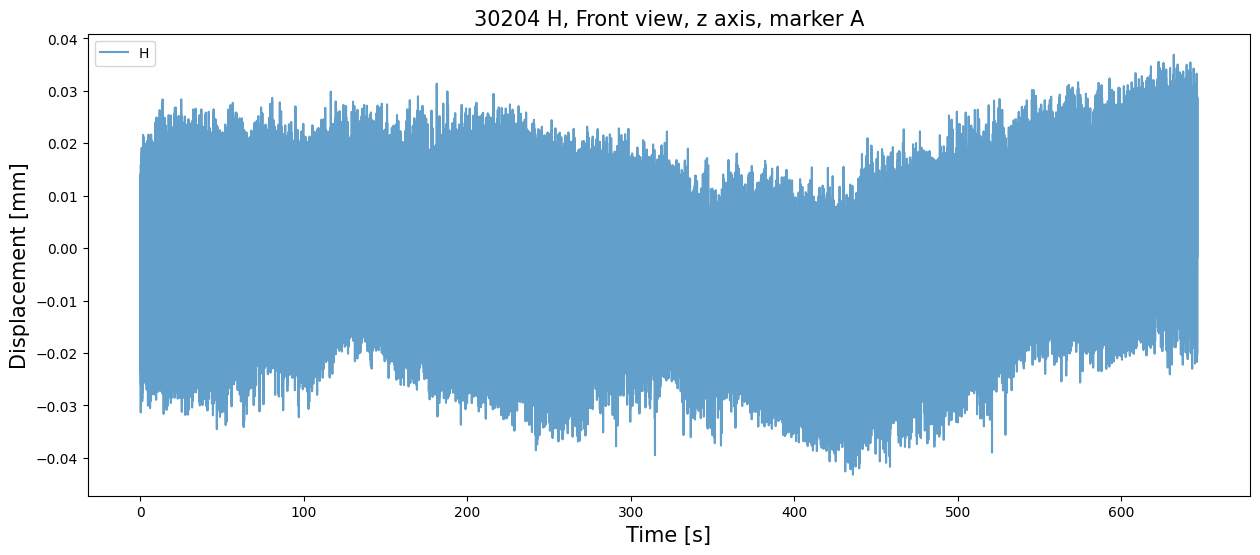

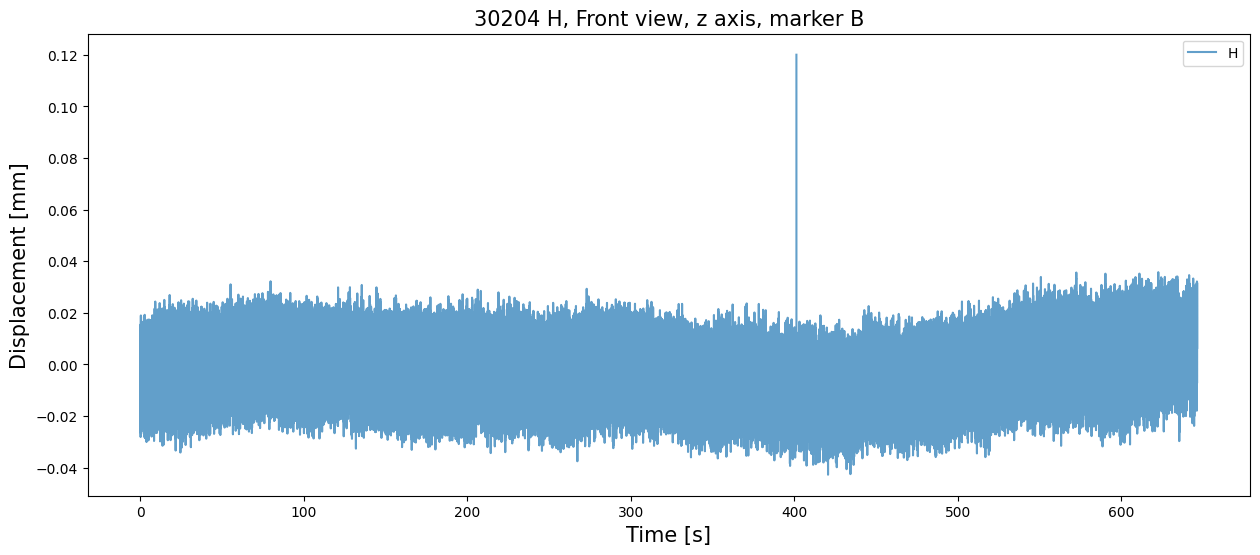

In [4]:
from funs import *

#####################################
# 그래프 보고자 하는 타겟 디렉토리 설정     
target_dir = '../output/1004'
######################################

dir_list = get_dir_list(target_dir)

compare_graphs(dir_list)